In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import librosa
from scipy.io import wavfile
import numpy as np
import pandas as pd
import sklearn as sk
import tensorflow as tf
import torch
from keras import models
from keras import layers
from sklearn import model_selection
from sklearn.metrics import confusion_matrix

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
def extract_feature(file_name):
    """
    Extracts 193 chromatographic features from sound file. 
    including: MFCC's, Chroma_StFt, Melspectrogram, Spectral Contrast, and Tonnetz
    NOTE: this extraction technique changes the time series nature of the data
    """
    audio_data, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(audio_data))
    mfcc = np.mean(librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(audio_data, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    # More possible features to add
#     tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X, ), sr=sample_rate).T,axis=0)
#     spec_cent = np.mean(librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate).T, axis=0)
#     spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=audio_data, sr=sample_rate).T, axis=0)
#     rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio_data, sr=sample_rate).T, axis=0)
#     zcr = np.mean(librosa.feature.zero_crossing_rate(audio_data).T, axis=0)

    features = []
    features.extend(mfcc) # 40 = 40
    features.extend(chroma) # 12 = 52
    features.extend(mel) # 128 = 180
    features.extend(contrast) # 7 = 187
    
    
#     features.extend(tonnetz) # 6 = 193
#     features.extend(spec_cent)
#     features.extend(spec_bw)
#     features.extend(rolloff)
#     features.extend(zcr)

    return np.array(features)

In [4]:
def load_all_wav_files(base_directory="./data", load_birds=False):
    #THIS WILL TAKE A WHILE!!!!!
    all_data = []
    all_labels = []
    #UltraSound8K
    print("loading Ultrasound8k")
    metadata = pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")
    for root, dirs, files in os.walk("./UrbanSound8K"):
        print(root, str(len(dirs)), str(len(files)), len(all_data))
#       # This is in here for quick tests - only loads first Ultrasound8k folder (instead of all of them)
#         if len(all_data) > 0: 
#             break
        for idx, file in enumerate(files):
            if file.endswith('.wav'):
                if(len(all_data) % 100 == 0):
                    print(str(len(all_data)))
                fname = os.path.join(root, file)
                features = extract_feature(fname)
                label = metadata[metadata.slice_file_name == file]["class"].tolist()[0]
                all_data.append(features)
                all_labels.append(label)


    if load_birds:
        print("Loading birds")
        for root, dirs, files in os.walk("./data/warblrb10k_public_wav/train/hasbird"):
            print(root, str(len(dirs)), str(len(files)), len(all_data))
            for file in files:
                if(len(all_data) % 100 == 0):
                    print(str(len(all_data)))
                if file.endswith('.wav'):
                    audio_data, _sampling_rate = librosa.load(os.path.join(root, file))
                    features = extract_feature(fname)
                    all_data.append(features)
                    all_labels.append("bird")

    return np.array(all_data), np.array(all_labels)

In [5]:
all_data, all_labels = load_all_wav_files("./UrbanSound8K", False)

loading Ultrasound8k
./UrbanSound8K 2 3 0
./UrbanSound8K\audio 10 1 0
./UrbanSound8K\audio\fold1 0 874 0
0
100
200
300
400
500
600
700
800
./UrbanSound8K\audio\fold10 0 838 873
900
1000
1100
1200
1300
1400
1500
1600
1700
./UrbanSound8K\audio\fold2 0 889 1710
1800
1900
2000
2100
2200
2300
2400
2500
./UrbanSound8K\audio\fold3 0 926 2598
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
./UrbanSound8K\audio\fold4 0 991 3523
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
./UrbanSound8K\audio\fold5 0 937 4513
4600
4700
4800
4900
5000
5100
5200
5300
5400
./UrbanSound8K\audio\fold6 0 824 5449
5500
5600
5700
5800
5900
6000
6100
6200
./UrbanSound8K\audio\fold7 0 839 6272
6300
6400
6500
6600
6700
6800
6900
7000
7100
./UrbanSound8K\audio\fold8 0 807 7110
7200
7300
7400
7500
7600
7700
7800
7900
./UrbanSound8K\audio\fold9 0 817 7916
8000
8100
8200
8300
8400
8500
8600
8700
./UrbanSound8K\metadata 0 2 8732


In [6]:
print(all_data.shape)
classes = list(set(all_labels))
n_classes = len(classes)
print(classes)
numeric_labels = np.array([classes.index(label) for label in all_labels])

(8732, 187)
['air_conditioner', 'gun_shot', 'street_music', 'car_horn', 'children_playing', 'engine_idling', 'dog_bark', 'siren', 'drilling', 'jackhammer']


In [7]:
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(all_data, numeric_labels, test_size=0.2, shuffle=True)

In [8]:
type(x_train)

numpy.ndarray

In [9]:
type(y_train)

numpy.ndarray

In [10]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
history = model.fit(x_train, y_train, epochs=40, batch_size=128)

Epoch 1/40
6985/6985 [==============================] - 0s 58us/step - loss: 3.5123 - accuracy: 0.3971
Epoch 2/40
6985/6985 [==============================] - 0s 19us/step - loss: 1.1954 - accuracy: 0.6246
Epoch 3/40
6985/6985 [==============================] - 0s 20us/step - loss: 0.9257 - accuracy: 0.7055
Epoch 4/40
6985/6985 [==============================] - 0s 21us/step - loss: 0.7712 - accuracy: 0.7555
Epoch 5/40
6985/6985 [==============================] - 0s 20us/step - loss: 0.6333 - accuracy: 0.8057
Epoch 6/40
6985/6985 [==============================] - 0s 19us/step - loss: 0.5658 - accuracy: 0.8255
Epoch 7/40
6985/6985 [==============================] - 0s 19us/step - loss: 0.5125 - accuracy: 0.8445
Epoch 8/40
6985/6985 [==============================] - 0s 20us/step - loss: 0.4707 - accuracy: 0.8553
Epoch 9/40
6985/6985 [==============================] - 0s 19us/step - loss: 0.4790 - accuracy: 0.8521
Epoch 10/40
6985/6985 [==============================] - 0s 20us/step - l

In [13]:
test_loss, test_acc = model.evaluate(x_test,y_test)


1747/1747 [==============================] - 0s 44us/step


In [14]:
print('test_acc: ',test_acc)

test_acc:  0.9244418740272522


In [15]:
y_predictions = model.predict(x_test)

In [16]:
y_pred = np.argmax(y_predictions, axis=1)

In [17]:
y_pred

array([2, 8, 6, ..., 7, 0, 5], dtype=int64)

In [18]:
y_test

array([2, 8, 6, ..., 7, 3, 5])

In [19]:
cm = confusion_matrix(y_test, y_pred)

In [20]:
cm

array([[215,   0,   0,   0,   0,   1,   0,   0,   0,   3],
       [  0,  76,   0,   0,   4,   0,   0,   0,   1,   0],
       [  4,   0, 175,   3,   5,   0,   0,   4,   6,   3],
       [  2,   0,   1,  85,   0,   3,   3,   2,   3,   2],
       [  5,   1,  10,   0, 166,   0,   1,   2,   0,   2],
       [  1,   0,   1,   0,   2, 186,   0,   1,   0,   1],
       [  3,   3,   9,   1,  13,   1, 161,   4,   0,   0],
       [  0,   0,   0,   2,   3,   1,   0, 187,   1,   0],
       [  1,   0,   2,   0,   1,   0,   3,   0, 184,   3],
       [  0,   0,   1,   0,   0,   0,   0,   0,   3, 180]], dtype=int64)

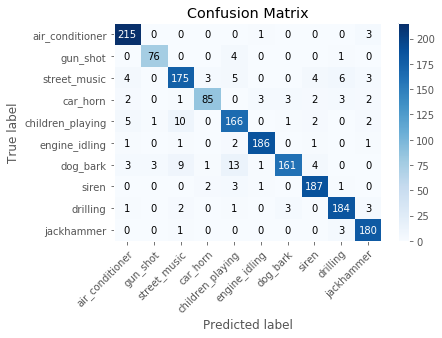

In [21]:
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes,
       yticklabels=classes,
       title="Confusion Matrix",
       ylabel='True label',
       xlabel='Predicted label')
ax.set_ylim(len(classes)-0.5, -0.5)
ax.set_aspect('auto')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.grid(None)
plt.show()